<a href="https://colab.research.google.com/github/taiwotman/TaiwotmanGoogleColab/blob/main/COVID_HOSPITAL_TREATMENT_Predicting_Patient's_Length_of_Stay(LOS)_using_Kaggle_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Multi-Class Classification of COVID-19 Patients based on Length of Stay**

***Description***: **[COVID HOSPITAL TREATMENT](https://www.kaggle.com/arashnic/covid19-hospital-treatment)**

Kaggle dataset available for download: [data](https://www.kaggle.com/arashnic/covid19-hospital-treatment/download)



***Authored by:*** Taiwo O. Adetiloye | [Website](https://taiwotman.github.io)

***Date:*** March 15, 2021

---




### **1. SET UP**

**Mount content from Google Drive**


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Java 8**

In [15]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

**Install pyspark libraries**

In [16]:
!pip install -q findspark
!pip install pyspark
!pip install matplotlib


**Set JAVA_HOME and SPARK_HOME**

In [17]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"


**Ensure spark is set up and running.**


In [18]:
import findspark 
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [19]:

from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local')\
.appName("Predicting LOS for High Risk Patient")\
.getOrCreate()

In [20]:
spark

**Read file from the mounted drive to spark dataframe**

In [21]:
filepath = "/content/drive/MyDrive/Colab Notebooks/data/host_train.csv" # Change this to your data filepath

df  = spark.read.option("header", "true").csv(filepath)


### **2. Data Preparation**


In [22]:
df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Hospital_type: string (nullable = true)
 |-- Hospital_city: string (nullable = true)
 |-- Hospital_region: string (nullable = true)
 |-- Available_Extra_Rooms_in_Hospital: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Ward_Type: string (nullable = true)
 |-- Ward_Facility: string (nullable = true)
 |-- Bed_Grade: string (nullable = true)
 |-- patientid: string (nullable = true)
 |-- City_Code_Patient: string (nullable = true)
 |-- Type of Admission: string (nullable = true)
 |-- Illness_Severity: string (nullable = true)
 |-- Patient_Visitors: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Admission_Deposit: string (nullable = true)
 |-- Stay_Days: string (nullable = true)



In [23]:
print(f"Counts of rows/samples: {df.count()}")
print(f"Counts of columns/features: {len(df.columns)}")

Counts of rows/samples: 318438
Counts of columns/features: 18


In [24]:
df.show(100)

+-------+--------+-------------+-------------+---------------+---------------------------------+------------------+---------+-------------+---------+---------+-----------------+-----------------+----------------+----------------+-----+-----------------+------------------+
|case_id|Hospital|Hospital_type|Hospital_city|Hospital_region|Available_Extra_Rooms_in_Hospital|        Department|Ward_Type|Ward_Facility|Bed_Grade|patientid|City_Code_Patient|Type of Admission|Illness_Severity|Patient_Visitors|  Age|Admission_Deposit|         Stay_Days|
+-------+--------+-------------+-------------+---------------+---------------------------------+------------------+---------+-------------+---------+---------+-----------------+-----------------+----------------+----------------+-----+-----------------+------------------+
|      1|       8|            2|            3|              2|                                3|      radiotherapy|        R|            F|      2.0|    31397|              7.0|    

**Observations using Dataframe Schema**


\begin{array}{ccc}
Column\:Name&Critical\:Factor&Data\:Type&Transformation\:required&Transformation\\
case\_id & No &String &No&N/A \\ 
Hospital & Yes &String&Yes&String\:to\:integer\\
Hospital\_type & Yes &String&Yes& String\:to\:integer\\
Hospital\_city & Yes &String&Yes&String\:to\:integer\\
Hospital\_region & Yes &String&Yes&String\:to\:integer\\
Available\_extra\_rooms\_in\_hospital & Yes &String&Yes&String\:to\:integer\\
Department & Yes &String&Yes&String\:to\:index\\
Ward\_type & Yes &String&Yes&String\:to\:index\\
Ward\_facility & Yes &String&Yes&String\:to\:index\\
Bed\_grade & Yes &String&Yes&String\:to\:integer\\
Patientid & No &String&Yes&String\:to\:integer\\
City\_Code\_Patient & Yes &String&Yes&String\:to\:integer\\
Type\:of\:Admission & Yes &String&Yes&String\:to\:index\\
Illness\_Severity & Yes &String&Yes&String\:to\:index\\
Patient\_Visitors & Yes &String&Yes&String\:to\:integer\\
Age & Yes &String&Yes&String\:to\:index\\
Admission\_Deposit& Yes &String&Yes&String\:to\:integer\\
Stay\_Days & Target\:variable\:or\:Label &String&Yes&String\:to\:index\\
\end{array}




**First Level Transformation: Rename selected columns**

In [25]:
## Rename column "Type of Admission" and "patientid"
df2 = df.withColumnRenamed("Type of Admission", "Type_of_Admission")\
      .withColumnRenamed("patientid", "Patient_id")

## Convert all columns to lower case for uniformity
df3 = df2.toDF(*[c.lower() for c in df2.columns])
df3.printSchema()



root
 |-- case_id: string (nullable = true)
 |-- hospital: string (nullable = true)
 |-- hospital_type: string (nullable = true)
 |-- hospital_city: string (nullable = true)
 |-- hospital_region: string (nullable = true)
 |-- available_extra_rooms_in_hospital: string (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: string (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: string (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: string (nullable = true)
 |-- stay_days: string (nullable = true)



**Second Level Transformation: Change selected columns from String to Integer**

In [26]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

string_to_integer_list = ['hospital', 'hospital_type', 'hospital_city','hospital_region','available_extra_rooms_in_hospital',
                          'bed_grade','city_code_patient','patient_visitors','admission_deposit']
df4 = df3
for col in string_to_integer_list:
  df4 = df4.withColumn(col, F.col(col).astype(IntegerType()))

df4.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)



**Third Level Transformation: Change selected columns from String to Index**



In [27]:
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F

string_to_integer_list = ['department','ward_facility', 'ward_type','illness_severity','type_of_admission']

def custom_stringindex(df, col):
  output = col + "_index"
  indexer = StringIndexer(inputCol=col, outputCol=output)
  indexed = indexer.fit(df).transform(df)
  
  return indexed


df5 = df4
for col in string_to_integer_list:
  df5 = custom_stringindex(df5, col)
 
df5.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)
 |-- department_index: double (nullable = false)
 |-- ward_facility_index: double (nullable = false)
 |-- ward_type_index: double (nullable = false)
 |-- illness_severity_inde

### **3. Data Insight**

**Using Group By**

In [28]:
from pyspark.sql.functions import col

df5.groupBy("stay_days") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("illness_severity") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("ward_type") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("ward_facility") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("department") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("age") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------------------+-----+
|         stay_days|count|
+------------------+-----+
|             21-30|87491|
|             11-20|78139|
|             31-40|55159|
|             51-60|35018|
|              0-10|23604|
|             41-50|11743|
|             71-80|10254|
|More than 100 Days| 6683|
|             81-90| 4838|
|            91-100| 2765|
|             61-70| 2744|
+------------------+-----+

+----------------+------+
|illness_severity| count|
+----------------+------+
|        Moderate|175843|
|           Minor| 85872|
|         Extreme| 56723|
+----------------+------+

+---------+------+
|ward_type| count|
+---------+------+
|        R|127947|
|        Q|106165|
|        S| 77794|
|        P|  5046|
|        T|  1477|
|        U|     9|
+---------+------+

+-------------+------+
|ward_facility| count|
+-------------+------+
|            F|112753|
|            E| 55351|
|            D| 51809|
|            C| 35463|
|            B| 35156|
|            A| 27906|
+------------

###**4. Machine Learning**

In [29]:
input_variable = ['hospital', 'hospital_type', 'hospital_city','hospital_region','available_extra_rooms_in_hospital',
                  'bed_grade','city_code_patient','patient_visitors','admission_deposit',
                  'department_index', 'ward_facility_index', 'ward_type_index', 'illness_severity_index',
                  'type_of_admission_index']

label = ['stay_days_index']
                    

**Feature engineering**

*Partition training and test sets*

In [30]:
# set seed for reproducibility
(trainingData, testData) = df5.randomSplit([0.8, 0.2], seed = 200000)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 254660
Test Dataset Count: 63778


*Vector Assembler*

In [31]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=input_variable,
    outputCol="features",
    handleInvalid ="skip")

df6 = assembler.transform(df5)




Principal Component Analysis(PCA)


In [32]:
from pyspark.ml.feature import PCA

pca =PCA(k=10, inputCol="features", outputCol="pcaFeatures") 



Standardization


In [33]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="pcaFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

**Decison Tree**

In [34]:
from pyspark.ml.feature import IndexToString
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

labelIndexer = StringIndexer(inputCol="stay_days", outputCol="stay_days_index").fit(df6)
# Train a LogisticRegression model.
dt = DecisionTreeClassifier(labelCol="stay_days_index", featuresCol="scaledFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)


In [35]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, pca, scaler, dt, labelConverter])


In [36]:
model = pipeline.fit(trainingData)

In [37]:
predictions_df = model.transform(testData)

predictions_df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)
 |-- department_index: double (nullable = false)
 |-- ward_facility_index: double (nullable = false)
 |-- ward_type_index: double (nullable = false)
 |-- illness_severity_inde

In [38]:
# Select example rows to display.
predictions_df.select("case_id", "illness_severity","type_of_admission", "stay_days", "predictedLabel" ).show(40)

+-------+----------------+-----------------+------------------+--------------+
|case_id|illness_severity|type_of_admission|         stay_days|predictedLabel|
+-------+----------------+-----------------+------------------+--------------+
|      1|         Extreme|        Emergency|              0-10|         21-30|
|    100|        Moderate|           Urgent|             11-20|         11-20|
| 100000|        Moderate|           Trauma|             31-40|         21-30|
| 100002|        Moderate|           Urgent|             21-30|         21-30|
| 100003|        Moderate|           Urgent|             21-30|          0-10|
| 100004|         Extreme|           Trauma|             21-30|         21-30|
| 100007|         Extreme|        Emergency|             11-20|         11-20|
| 100010|           Minor|           Trauma|             21-30|         51-60|
| 100022|        Moderate|           Trauma|             11-20|         21-30|
| 100026|        Moderate|           Trauma|        

**Random Forest**

In [44]:
from pyspark.ml.feature import IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

labelIndexer = StringIndexer(inputCol="stay_days", outputCol="stay_days_index").fit(df6)
# Train a LogisticRegression model.
rf  = RandomForestClassifier(labelCol="stay_days_index", featuresCol="scaledFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)


In [45]:
# Chain indexers and tree in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, assembler, pca, scaler, rf, labelConverter])

In [41]:
model_rf = pipeline_rf.fit(trainingData)

In [46]:
predictions_rf = model_rf.transform(testData)

**Multiclass Classification Evaluation**

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Select (prediction, true label) and compute the accuracy and test error
def customMulticlassClassificationEvaluator(modelname, predictions):
  evaluator = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)

  evaluator2 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedRecall")
  weightedRecall = evaluator2.evaluate(predictions)

  evaluator3 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedPrecision")
  weightedPrecision = evaluator3.evaluate(predictions)

  evaluator4 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedTruePositiveRate")
  weightedTruePositiveRate = evaluator4.evaluate(predictions)

  evaluator5 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="truePositiveRateByLabel")
  truePositiveRateByLabel = evaluator5.evaluate(predictions)

  evaluator6 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="falsePositiveRateByLabel")
  falsePositiveRateByLabel = evaluator6.evaluate(predictions)

  evaluator7 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="precisionByLabel")
  precisionByLabel = evaluator7.evaluate(predictions)

  evaluator8 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedFMeasure")
  weightedFMeasure = evaluator8.evaluate(predictions)

  evaluator9 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="fMeasureByLabel")
  fMeasureByLabel = evaluator9.evaluate(predictions)

  evaluator10 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="recallByLabel")
  recallByLabel = evaluator10.evaluate(predictions)

  evaluator11 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="logLoss")
  logLoss = evaluator11.evaluate(predictions)

  evaluator12 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="hammingLoss")
  hammingLoss = evaluator12.evaluate(predictions)


  evaluator13 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="f1")
  f1 = evaluator13.evaluate(predictions)


  print(f'Model name: {modelname}')
  print("\tAccuracy = %g " %(accuracy))
  print("\tF1 = %g " %(f1))
  print("\tTest Error = %g " %(1.0 - accuracy))
  print("\tTrue Positive Rate By Label = %g " %(truePositiveRateByLabel)) 
  print("\tFalse Positive Rate By Label = %g " %(falsePositiveRateByLabel)) 
  print("\tPrecision By Label = %g " %(precisionByLabel))
  print("\tRecall By Label = %g " %(recallByLabel))
  print("\tFMeasure By Label = %g " %(fMeasureByLabel))
  print("\tWeighted Recall = %g " %(weightedRecall))
  print("\tWeighted Precision = %g " %(weightedPrecision))
  print("\tWeighted True Positive Rate = %g " %(weightedTruePositiveRate))  
  print("\tWeighted FMeasure = %g " %(weightedFMeasure))
  print("\tLog Loss = %g " %(logLoss))
  print("\tHamming Loss = %g " %(hammingLoss))



In [ ]:
# MulticlassClassification Evaluation for DecisionTree Classifier
customMulticlassClassificationEvaluator("DecisionTreeClassifier", predictions_df)

In [ ]:
# MulticlassClassification Evaluation for RandomForest Classifier
customMulticlassClassificationEvaluator("RandomForest", predictions_rf)

***TO DO***

**Observation:** Possible case of overfitting. Investigate root cause.

**Proposed solution:** Improve the model accuracy by applying Synthetic Minority Oversampling Technique(SMOTE) to address the problem of imbalance dataset







#### **Virtualization**

#### ***Correlation Matrix***

##### **Decision Tree**

In [48]:
df1= predictions_df.toPandas()

In [49]:
df1.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,hospital,hospital_type,hospital_city,hospital_region,available_extra_rooms_in_hospital,bed_grade,city_code_patient,patient_visitors,admission_deposit,department_index,ward_facility_index,ward_type_index,illness_severity_index,type_of_admission_index,stay_days_index,prediction
hospital,1.00,0.04,0.13,-0.14,-0.06,-0.01,-0.02,-0.03,0.04,0.01,0.13,0.01,0.00,-0.00,0.04,0.01
hospital_type,0.04,1.00,-0.01,0.27,-0.10,0.03,0.06,-0.04,0.02,-0.03,0.26,0.22,0.00,-0.01,0.05,0.06
hospital_city,0.13,-0.01,1.00,0.01,-0.04,-0.05,-0.03,0.02,-0.04,-0.02,0.10,-0.04,-0.00,0.04,0.01,0.07
hospital_region,-0.14,0.27,0.01,1.00,-0.01,-0.04,0.15,-0.02,0.07,-0.03,0.51,0.19,0.01,0.05,0.04,0.04
available_extra_rooms_in_hospital,-0.06,-0.10,-0.04,-0.01,1.00,-0.12,-0.01,0.09,-0.14,-0.09,-0.05,-0.05,-0.02,0.04,-0.10,-0.18
bed_grade,-0.01,0.03,-0.05,-0.04,-0.12,1.00,-0.01,0.09,0.08,0.05,-0.08,-0.02,-0.05,-0.06,0.04,0.28
city_code_patient,-0.02,0.06,-0.03,0.15,-0.01,-0.01,1.00,-0.01,0.03,-0.01,0.14,0.08,0.01,0.04,0.02,-0.00
patient_visitors,-0.03,-0.04,0.02,-0.02,0.09,0.09,-0.01,1.00,-0.15,0.01,-0.03,0.05,0.02,-0.02,0.40,0.67
admission_deposit,0.04,0.02,-0.04,0.07,-0.14,0.08,0.03,-0.15,1.00,0.08,0.02,-0.03,-0.02,-0.08,-0.09,-0.11
department_index,0.01,-0.03,-0.02,-0.03,-0.09,0.05,-0.01,0.01,0.08,1.00,-0.01,0.02,0.00,-0.02,-0.00,0.05


##### **Random Forest**

In [52]:
df2= predictions_rf.toPandas()

In [53]:
df2.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,hospital,hospital_type,hospital_city,hospital_region,available_extra_rooms_in_hospital,bed_grade,city_code_patient,patient_visitors,admission_deposit,department_index,ward_facility_index,ward_type_index,illness_severity_index,type_of_admission_index,stay_days_index,prediction
hospital,1.00,0.04,0.13,-0.14,-0.06,-0.01,-0.02,-0.03,0.04,0.01,0.13,0.01,0.00,-0.00,0.04,0.01
hospital_type,0.04,1.00,-0.01,0.27,-0.10,0.03,0.06,-0.04,0.02,-0.03,0.26,0.22,0.00,-0.01,0.05,0.06
hospital_city,0.13,-0.01,1.00,0.01,-0.04,-0.05,-0.03,0.02,-0.04,-0.02,0.10,-0.04,-0.00,0.04,0.01,0.06
hospital_region,-0.14,0.27,0.01,1.00,-0.01,-0.04,0.15,-0.02,0.07,-0.03,0.51,0.19,0.01,0.05,0.04,0.04
available_extra_rooms_in_hospital,-0.06,-0.10,-0.04,-0.01,1.00,-0.12,-0.01,0.09,-0.14,-0.09,-0.05,-0.05,-0.02,0.04,-0.10,-0.22
bed_grade,-0.01,0.03,-0.05,-0.04,-0.12,1.00,-0.01,0.09,0.08,0.05,-0.08,-0.02,-0.05,-0.06,0.04,0.30
city_code_patient,-0.02,0.06,-0.03,0.15,-0.01,-0.01,1.00,-0.01,0.03,-0.01,0.14,0.08,0.01,0.04,0.02,-0.01
patient_visitors,-0.03,-0.04,0.02,-0.02,0.09,0.09,-0.01,1.00,-0.15,0.01,-0.03,0.05,0.02,-0.02,0.40,0.69
admission_deposit,0.04,0.02,-0.04,0.07,-0.14,0.08,0.03,-0.15,1.00,0.08,0.02,-0.03,-0.02,-0.08,-0.09,-0.07
department_index,0.01,-0.03,-0.02,-0.03,-0.09,0.05,-0.01,0.01,0.08,1.00,-0.01,0.02,0.00,-0.02,-0.00,0.06


#### ***3D Scatter Plot***

In [55]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [63]:
def scatter_plot(df, z_value):
  if z_value:
    try:
      fig=plt.figure(figsize=(10,10))
      fig.subplots_adjust(bottom=0.2)
      ax = fig.add_subplot(111)
      z_label = z_value.replace('_index', '').replace('_', ' ').title()
      
      ax= plt.axes(projection='3d')
      ax.dist = 10
      ax.set_xlabel('Stay days')
      ax.set_ylabel('Prediction')
      ax.set_zlabel(z_label)
      ax.set_title(f'Predicted Vs Stay days Vs {z_label}')
      ax.scatter(df['stay_days'],df['predictedLabel'],df[z_value])
      plt.show()
    except ValueError:
      pass
    else: pass


z_value = 'illness_severity_index'

##### **Decision Tree**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


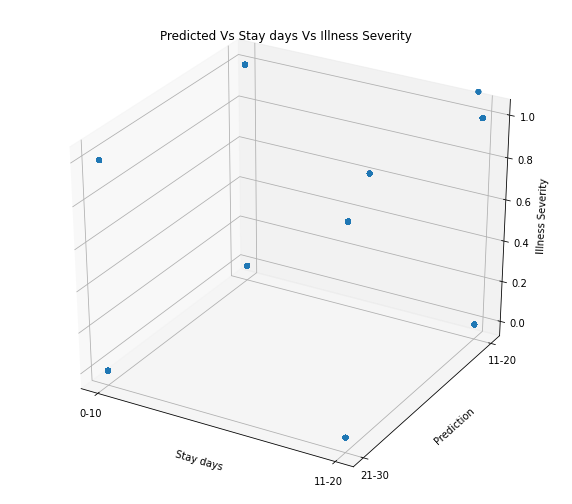

In [65]:
scatter_plot(df1, z_value)

##### **Random Forest**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


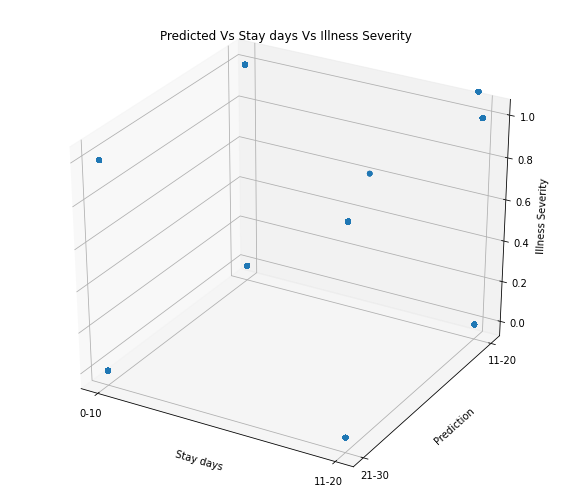

In [66]:
scatter_plot(df2, z_value)